In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Business Understanding & Goals

Buisness context:
The client is one of the leading online market place in India and would like partner with Analytixlabs.
Client wants help in measuring, managing and analysing performance of business.
Analytixlabs has hired you as an analyst for this project where client asked you to provide data
driven insights about business and understand customer, seller behaviors, product behavior and
channel behavior etc…

My objective:
1) Perform EDA
- Understanding how many new customers acquired every month
- Understand the retention of customers on month on month basis
- How the revenues from existing/new customers on month on month basis
- Understand the trends/seasonality of sales, quantity by category, location, month,
week, day, time, channel, payment method etc…
- Popular Products by month, seller, state, category. (Will be added in the future)
2) Performing Customers/sellers Segmentation
3) Cross-Selling (Which products are selling together)





CLV, RFM, BG-NBD

# Data Understanding & Cleaning

Let's see all dataset

In [12]:
customers = pd.read_csv('Datasets/CUSTOMERS.csv')
geo = pd.read_csv('Datasets/GEO_LOCATION.csv')
order_items = pd.read_csv('Datasets/ORDER_ITEMS.csv')
order_payments = pd.read_csv('Datasets/ORDER_PAYMENTS.csv')
order_review_ratings = pd.read_csv('Datasets/ORDER_REVIEW_RATINGS.csv')
orders = pd.read_csv('Datasets/ORDERS.csv')
products = pd.read_csv('Datasets/PRODUCTS.csv')
sellers = pd.read_csv('Datasets/SELLERS.csv')

## Dataset Description

This dataset consists of 8 tables:

* **Customers**: Customers information.
* **Sellers**: Sellers information.
* **Products**: Product information.
* **Orders**: Orders info (IDs, status, dates).
* **Order_Items**: Details of items in orders.
* **Order_Payments**: Information about order payments.
* **Order_Review_Ratings**: Customer ratings and reviews.
* **Geo-Location**: Details of geographical locations.

For the first objective (Perform EDA) I'm going to create a dataframe with columns from these tables

In [13]:
# I will begin with table ORDERS
sales_data = orders.copy()

In [14]:
sales_data = sales_data.merge(customers, on='customer_id', how='left')

In [15]:
sales_data = sales_data.merge(order_items, on='order_id', how='left')

In [16]:
sales_data = sales_data.merge(order_payments, on='order_id', how='left')

In [17]:
sales_data = sales_data.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

In [18]:
# And I'm going to drop unnecessary columns
sales_data = sales_data.drop(columns=['order_status', 'customer_zip_code_prefix'])

# Exploratory Data Analysis

In [20]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115014 entries, 0 to 115013
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115014 non-null  object 
 1   customer_id                    115014 non-null  object 
 2   order_purchase_timestamp       115014 non-null  object 
 3   order_approved_at              115014 non-null  object 
 4   order_delivered_carrier_date   115014 non-null  object 
 5   order_delivered_customer_date  115014 non-null  object 
 6   order_estimated_delivery_date  115014 non-null  object 
 7   customer_unique_id             115014 non-null  object 
 8   customer_city                  115014 non-null  object 
 9   customer_state                 115014 non-null  object 
 10  order_item_id                  115014 non-null  int64  
 11  product_id                     115014 non-null  object 
 12  seller_id                     

From this output, I noticed that the timestamp columns need to be converted into datetime format for proper time-based analysis


In [21]:
datetime_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]
for col in datetime_cols:
    sales_data[col] = pd.to_datetime(sales_data[col], errors='coerce')

In [22]:
sales_data.duplicated().sum()

np.int64(0)

To understand how many new customers were acquired monthly, I created a new column called first_order_date, which marks the date of each customer's first purchase.

In [23]:
first_order = sales_data.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_order.columns = ['customer_unique_id', 'first_order_date']

sales_data = sales_data.merge(first_order, on='customer_unique_id', how='left')

Then I aggregated the data:

In [ ]:
first_order_by_month = (
    sales_data
    .groupby(sales_data['first_order_date'].dt.to_period('M'))['customer_unique_id']
    .nunique()
)

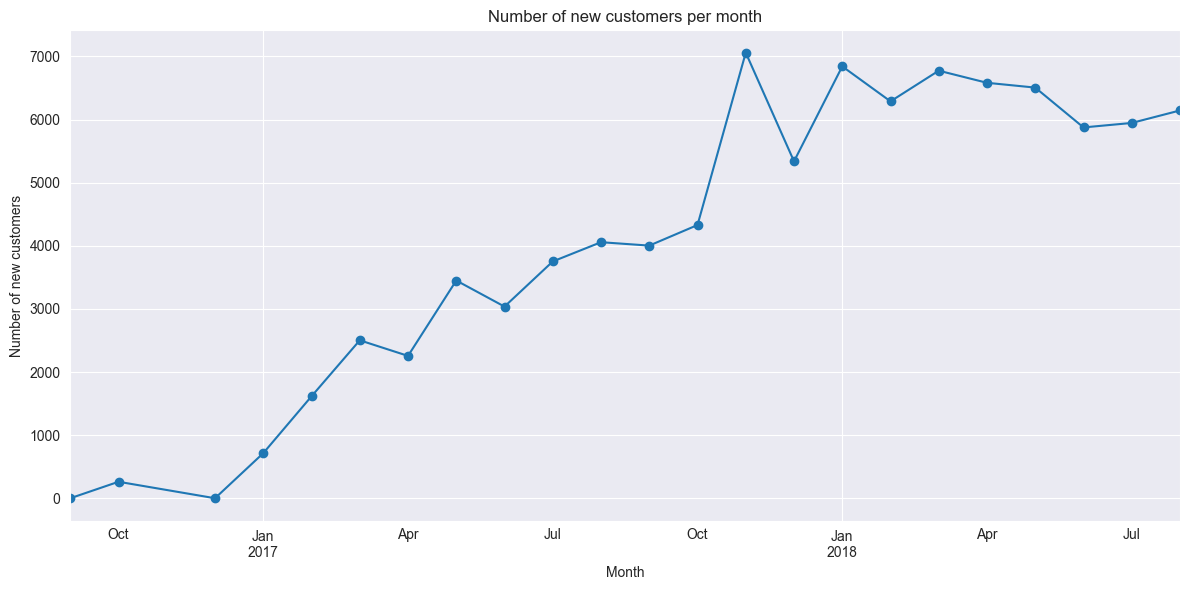

In [164]:
plt.figure(figsize=(12, 6))
first_order_by_month.plot(kind='line', marker='o')
plt.title('Number of new customers per month')
plt.xlabel('Month')
plt.ylabel('Number of new customers')
plt.grid(True)
plt.tight_layout()
plt.show()


From this plot, we can see that there are not many new customers at the beginning. Usually, when we analyze an existing business, we see a big spike at the beginning. But here, the numbers are quite low — that probably means this dataset starts from around the launch of the business or the platform

Later, I noticed growth in the number of new customers. A clear spike happens around October–November, most likely related to holiday shopping (Black Friday, Christmas). After New Year, there’s a smaller peak, but then the number drops a bit

### Understand the retention of customers on month on month basis

To analyze retention, I created a new dataset called cohort_data

In [206]:
cohort_data = sales_data[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'first_order_date']].drop_duplicates().copy()

order_month = cohort_data['order_purchase_timestamp'].dt.to_period('M')
cohort_month = cohort_data['first_order_date'].dt.to_period('M')
cohort_data['cohort_month'] = cohort_data['first_order_date'].dt.to_period("M")
cohort_data['cohort_index'] = (order_month.astype('int') - cohort_month.astype('int')) +1


In [207]:
pivot_table = pd.pivot_table(
    cohort_data,
    index='cohort_month',
    columns='cohort_index',
    values='customer_unique_id',
    aggfunc='nunique'
)

In [208]:
cohort_size = pivot_table.iloc[:, 0]

cohort_retention = pivot_table.divide(cohort_size, axis=0).round(3)

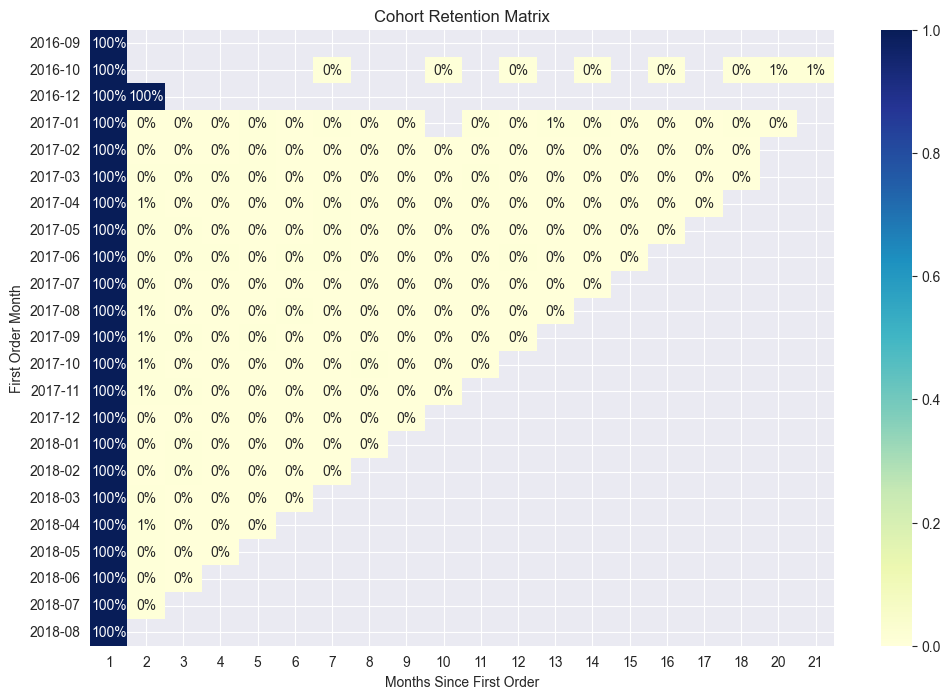

In [209]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Cohort Retention Matrix")
plt.ylabel("First Order Month")
plt.xlabel("Months Since First Order")
plt.show()


From this plot, we can see that due to the large number of new users, it doesn't show old users

In [226]:
cohort_data['customer_unique_id'].value_counts().value_counts()

count
1     90536
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: count, dtype: int64

More than 90% of customers ordered only once. That’s why the matrix was mostly filled with 0s.
By excluding those users, we can better understand how often real, active users come back

In [227]:
customer_order_counts = cohort_data.groupby('customer_unique_id')['order_id'].nunique()
repeat_customers = customer_order_counts[customer_order_counts > 1].index
filtered_sales_data = cohort_data[cohort_data['customer_unique_id'].isin(repeat_customers)]

In [237]:
pivot_table = pd.pivot_table(
    filtered_sales_data,
    index='cohort_month',
    columns='cohort_index',
    values='customer_unique_id',
    aggfunc='nunique'
)

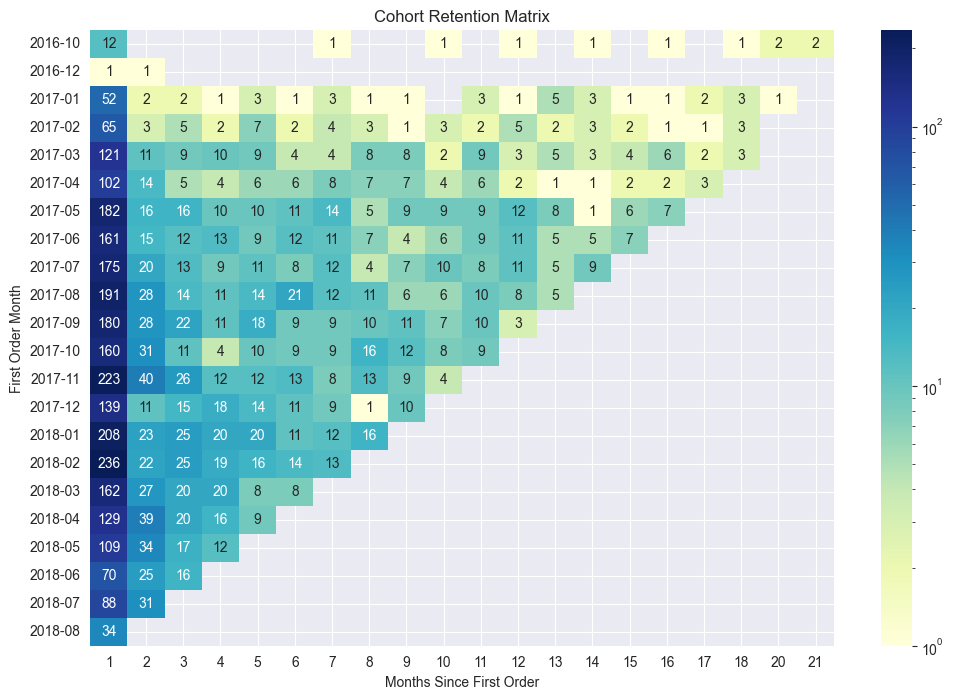

In [393]:
cohort_size = pivot_table.iloc[:, 0]

cohort_retention = pivot_table.divide(cohort_size, axis=0).round(3)

from matplotlib.colors import LogNorm

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", norm=LogNorm(), fmt='.0f')
plt.title("Cohort Retention Matrix")
plt.ylabel("First Order Month")
plt.xlabel("Months Since First Order")
plt.show()


Now from the cohort heatmap, I can see a pattern:
There’s a clear rise of returning customers before New Year, and after March 2018 the number of new customers starts to fall. So most of the orders later come from existing customers — not new ones

### Understand the trends/seasonality of sales

In [278]:
trends_data = sales_data[['order_id', 'customer_id', 'customer_unique_id', 'order_purchase_timestamp', 'customer_city', 'order_item_id', 'product_id', 'price', 'freight_value', 'payment_type', 'payment_sequential', 'payment_value', 'payment_installments', 'product_category_name', 'first_order_date']].copy()  

In [279]:
trends_data['month'] = sales_data['order_purchase_timestamp'].dt.to_period('M')
trends_data['day_of_week'] = sales_data['order_purchase_timestamp'].dt.dayofweek + 1
trends_data['hour'] = sales_data['order_purchase_timestamp'].dt.hour

In [301]:
monthly_sales = trends_data.groupby('month')['payment_value'].sum().reset_index()

<Axes: xlabel='month'>

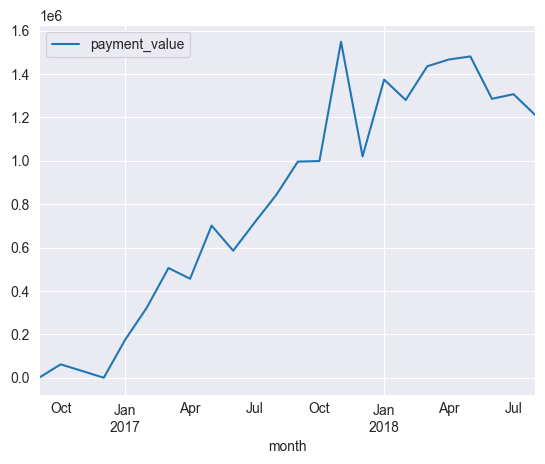

In [332]:
monthly_sales.plot(x='month', y='payment_value', kind='line')

In [312]:
sales_by_category = trends_data.groupby(['product_category_name', 'month'])['payment_value'].sum().reset_index()

C:\Users\HP\AppData\Local\Temp\ipykernel_69720\3091979926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['month'] = pd.to_datetime(filtered['month'].astype(str))


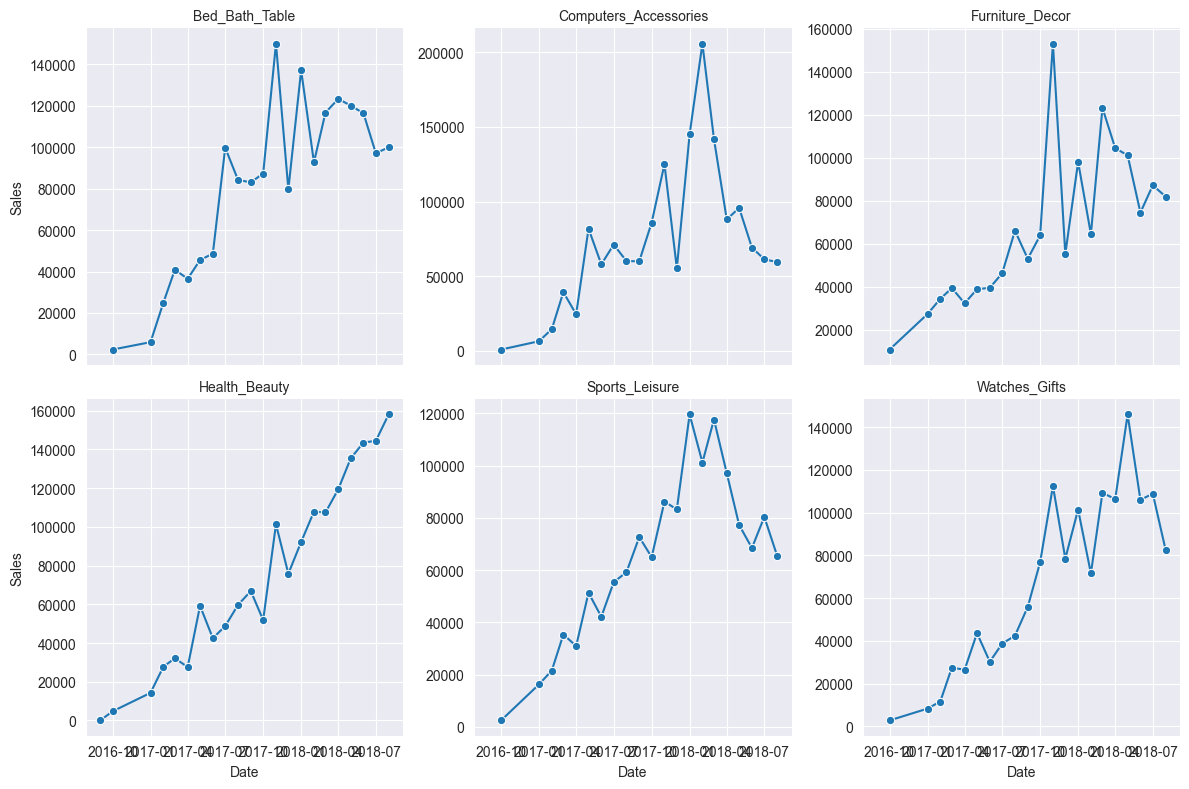

In [346]:
top_cat = sales_by_category.groupby('product_category_name')['payment_value'].sum().nlargest(6).index
filtered = sales_by_category[sales_by_category['product_category_name'].isin(top_cat)]
filtered['month'] = pd.to_datetime(filtered['month'].astype(str))

g = sns.FacetGrid(filtered, col='product_category_name', col_wrap=3, height=4, sharey=False)
g.map(sns.lineplot, 'month', 'payment_value', marker='o')

g.set_titles("{col_name}")
g.set_axis_labels("Date", "Sales")
plt.tight_layout()
plt.show()

### Performing Customers/sellers Segmentation

#### RGM segmentation

In [365]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [368]:
today = sales_data['order_purchase_timestamp'].max() + pd.Timedelta(days=1)


rfm = sales_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (today - x.max()).days,
    'order_id': 'nunique',
    'payment_value': 'sum'
})

In [369]:
rfm = rfm.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'payment_value': 'Monetary'
})

In [374]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

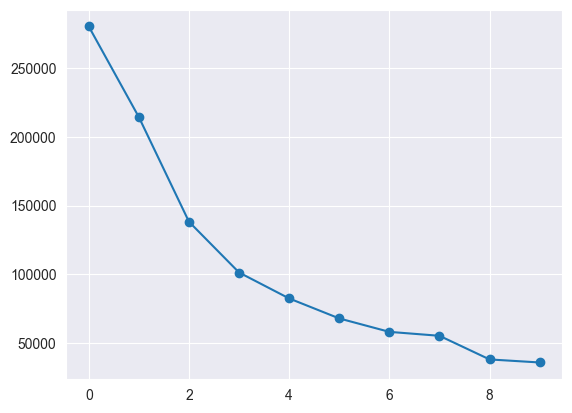

In [375]:
inertia = []
for i in range(1, 11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(inertia, marker="o")
    
    

In [376]:
kmeans = KMeans(n_clusters=3, random_state=42)

rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [378]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,238.45,1.00,199.49
1,220.24,2.11,570.67
2,334.00,1.00,109312.64


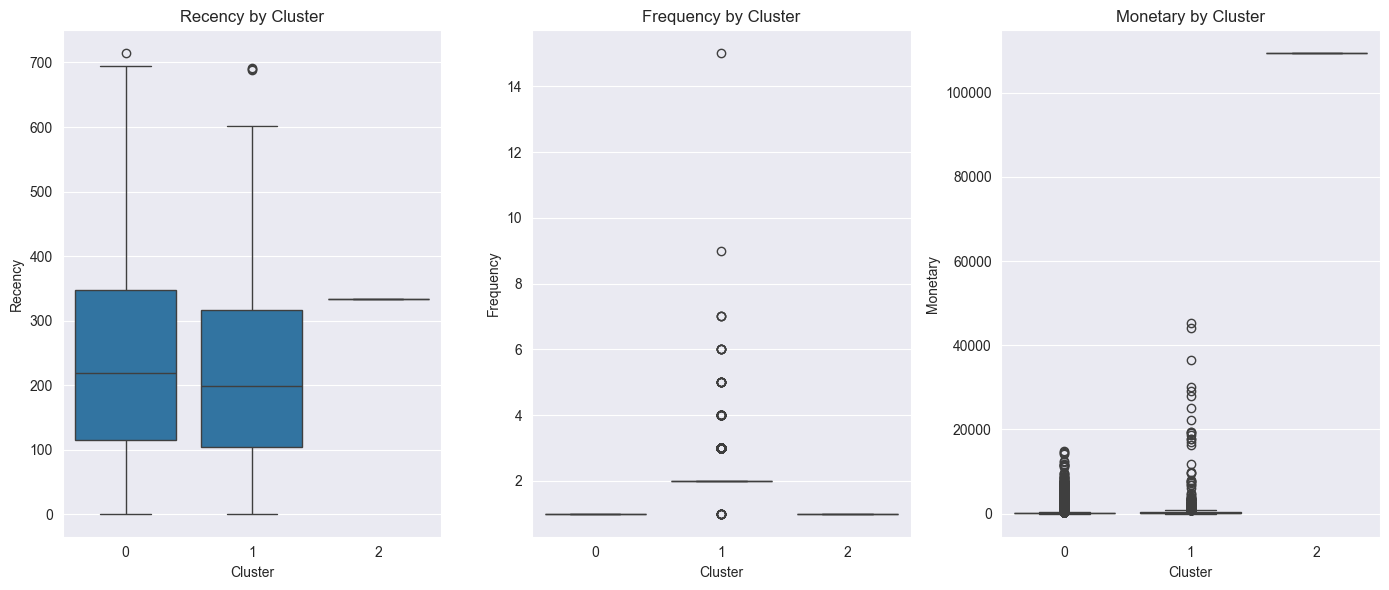

In [382]:
plt.figure(figsize=(14,6))
for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=metric, data=rfm)
    plt.title(f'{metric} by Cluster')
plt.tight_layout()
plt.show()

In [387]:
rfm['Cluster'].value_counts()

Cluster
0    90522
1     2813
2        1
Name: count, dtype: int64

According these plots, we can describe difference between clusters:

0 - These customers have high recency, low frequency, and low monetary value. This suggests they haven't made purchases in a while and show limited engagement. Reactivation campaigns might be effective here
1 - Customers in this cluster show lower recency, and have high frequency and high monetary value. These are the core, high-value customers and could be targeted with loyalty programs and special offers
2 - This cluster contains a single customer with high recency, low frequency, but very high monetary value. It's likely an outlier — a customer who made one large purchase